In [1]:
import pandas as pd

df1 = pd.read_csv('Telco_Customer_Churn.csv',)
print(df1.head(5))
print(df1.columns)

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [2]:
df2 = df1.loc[:,['tenure','InternetService','OnlineSecurity','TechSupport','Contract','MonthlyCharges','Churn']]
df2.head()

,tenure,InternetService,OnlineSecurity,TechSupport,Contract,MonthlyCharges,Churn
0,1,DSL,No,No,Month-to-month,29.85,No
1,34,DSL,Yes,No,One year,56.95,No
2,2,DSL,Yes,No,Month-to-month,53.85,Yes
3,45,DSL,Yes,Yes,One year,42.30,No
4,2,Fiber optic,No,No,Month-to-month,70.70,Yes


In [3]:
df2.describe()

,tenure,MonthlyCharges
count,7043.000000,7043.000000
mean,32.371149,64.761692
std,24.559481,30.090047
min,0.000000,18.250000
25%,9.000000,35.500000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.750000


In [4]:
df2.isnull().sum()

tenure             0
InternetService    0
OnlineSecurity     0
TechSupport        0
Contract           0
MonthlyCharges     0
Churn              0
dtype: int64

In [5]:
df2.groupby('InternetService')['InternetService'].agg('count')

InternetService
DSL            2421
Fiber optic    3096
No             1526
Name: InternetService, dtype: int64

In [6]:
df2.groupby('OnlineSecurity')['OnlineSecurity'].agg('count')

OnlineSecurity
No                     3498
No internet service    1526
Yes                    2019
Name: OnlineSecurity, dtype: int64

In [7]:
df2['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

<Axes: xlabel='InternetService', ylabel='count'>

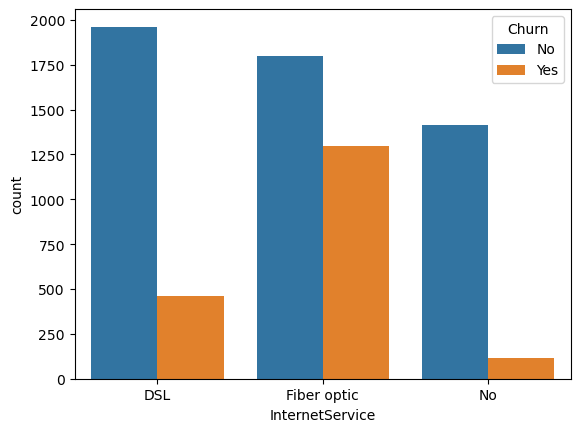

In [8]:
import seaborn as sns
sns.countplot(x="InternetService", hue="Churn", data=df2)

<Axes: xlabel='Contract', ylabel='count'>

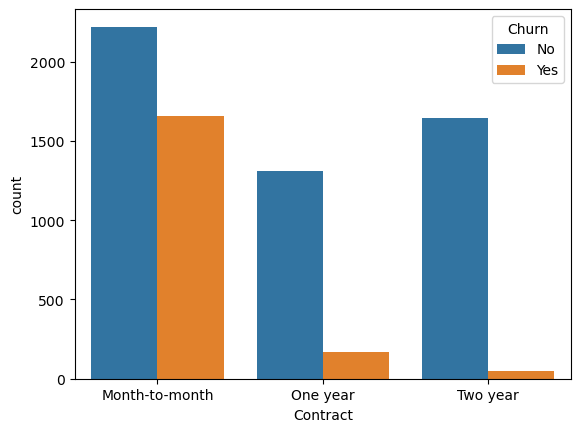

In [9]:
sns.countplot(x="Contract", hue="Churn", data=df2)

<Axes: xlabel='OnlineSecurity', ylabel='count'>

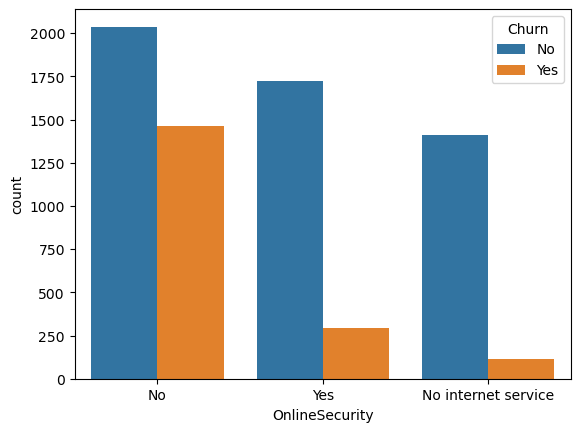

In [10]:
sns.countplot(x="OnlineSecurity", hue="Churn", data=df2)

In [11]:
df2['Churn'] = df2['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

cat_cols = ['InternetService', 'OnlineSecurity', 'TechSupport', 'Contract']
df3 = pd.get_dummies(df2, columns=cat_cols, drop_first=True,dtype=int)

df3.head()

,tenure,MonthlyCharges,Churn,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_No internet service,TechSupport_Yes,Contract_One year,Contract_Two year
0,1,29.85,0,0,0,0,0,0,0,0,0
1,34,56.95,0,0,0,0,1,0,0,1,0
2,2,53.85,1,0,0,0,1,0,0,0,0
3,45,42.30,0,0,0,0,1,0,1,1,0
4,2,70.70,1,1,0,0,0,0,0,0,0


In [12]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   tenure                              7043 non-null   int64  
 1   MonthlyCharges                      7043 non-null   float64
 2   Churn                               7043 non-null   int64  
 3   InternetService_Fiber optic         7043 non-null   int32  
 4   InternetService_No                  7043 non-null   int32  
 5   OnlineSecurity_No internet service  7043 non-null   int32  
 6   OnlineSecurity_Yes                  7043 non-null   int32  
 7   TechSupport_No internet service     7043 non-null   int32  
 8   TechSupport_Yes                     7043 non-null   int32  
 9   Contract_One year                   7043 non-null   int32  
 10  Contract_Two year                   7043 non-null   int32  
dtypes: float64(1), int32(8), int64(2)
memory us

In [13]:
!pip install lightgbm

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

# Assuming df3 is your preprocessed DataFrame with 'Churn' as target
X = df3.drop('Churn', axis=1)
y = df3['Churn']

# Check original class distribution
print("Original class distribution:\n", y.value_counts())

# Single stratified split: 80% train+val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train+Val class distribution:\n", y_train_val.value_counts())
print("Test class distribution:\n", y_test.value_counts())

# Now split train+val into 75% train and 25% val (which results in 60% train, 20% val overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

print("Train class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Define LightGBM classifier
lgbm = LGBMClassifier(random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63]
}

# GridSearchCV setup
grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Train model on balanced training data
grid.fit(X_train_bal, y_train_bal)

# Best model from grid search
best_model = grid.best_estimator_
print("\nBest Parameters Found:", grid.best_params_)

# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]

print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_prob))

# Evaluate on test set
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_test_prob))


Original class distribution:
 Churn
0    5174
1    1869
Name: count, dtype: int64
Train+Val class distribution:
 Churn
0    4139
1    1495
Name: count, dtype: int64
Test class distribution:
 Churn
0    1035
1     374
Name: count, dtype: int64
Train class distribution:
 Churn
0    3104
1    1121
Name: count, dtype: int64
Validation class distribution:
 Churn
0    1035
1     374
Name: count, dtype: int64
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3104, number of negative: 3104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 6208, number of used features: 10
[LightGBM] [Info] [binary:BoostF